In [1]:
import pandas as pd
# from scipy.special import linestyle

sales = pd.read_excel('Datos_examen_final_17Co2024_Grupo4.xlsx', sheet_name='Santa Ana')
sales["Mes"] = sales["Fecha"].dt.month # alternativa: dt.month_name()
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    float64       
 2   Mes     365 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 7.3 KB


## Ventas por mes en supermercado 'Santa Ana'

In [2]:
import matplotlib.pyplot as plt
import math
def plot_sales(data, plot_fun,title=None, n = 3, pad = 2.0, fig_size = (10,10)):
    m = math.ceil(len(data)/n)
    figure, axis = plt.subplots(m,n, figsize=fig_size)
    figure.tight_layout(pad = pad)
    for i in range(m*n):
        row = i//n
        col = i%n
        if i < len(data):
            if title:
                axis[row][col].set_title(f"{title}: {i+1}")
            plot_fun(data[i], axis[row][col], i)
        else: 
            axis[row][col].axis('off')
            
sales_per_month = [sales[sales["Mes"] == (i+1)]["Ventas"].values for i in range(12)]

In [3]:
# def month_sale_plot_fun(data, ax):    
#     ax.plot(range(len(data)), data, color='blue', linestyle=':', marker='o')
# plot_sales(sales_per_month,  month_sale_plot_fun , title='Month')

# from statsmodels.distributions.empirical_distribution import ECDF
# ecdf_per_month= list(map(lambda x: ECDF(x), sales_per_month))
# def month_ecdf_plot_fun(data, ax):    
#     # print('data:', data)
#     ax.plot(data.x, data.y, color='blue', linestyle=':', marker='o')
# plot_sales(ecdf_per_month,  month_ecdf_plot_fun , title='ECDF Month')


## 1 . Determinen intervalos de confianza empíricos para el supermercado 'Santa Ana' en cada mes, para significancias del 95% y el 99%.

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm
df = pd.DataFrame()
confidences = [0.95, 0.99]
month_names = ["January","February","March","April","May","June","July","August","September","October","November","December"]

for month_name, sales in zip(month_names, sales_per_month):
    for confidence in confidences:
        alpha = 1-confidence
        μ = np.mean(sales)
        σ = np.std(sales)
        new_σ = σ/np.sqrt(len(sales))
        # ppf = Φ^-1
        # asumiendo intervalo a dos colas:
        z_up = norm.ppf(1-alpha/2, loc=μ, scale=new_σ)
        z_down = norm.ppf(alpha/2, loc=μ, scale=new_σ)
        row = {
            'Month': month_name,
            'confidence:': confidence,
            'alpha': 1-confidence,
            'Intervalo(': z_down,
            ')': z_up
        }
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)         
display(df)

,Month,confidence:,alpha,Intervalo(,)
0,January,0.95,0.05,15284.181403,17338.422898
1,January,0.99,0.01,14961.436673,17661.167628
2,February,0.95,0.05,16789.912871,19013.785544
3,February,0.99,0.01,16440.517152,19363.181264
4,March,0.95,0.05,19244.117056,21095.591217
5,March,0.99,0.01,18953.229383,21386.478890
6,April,0.95,0.05,17456.478959,19410.258973
7,April,0.99,0.01,17149.517871,19717.220060
8,May,0.95,0.05,19255.999406,21073.128632
9,May,0.99,0.01,18970.507713,21358.620325


## 2. Realicen pruebas ANOVA para determinar si las ventas esperadas de todas las tiendas son iguales o no, con una significancia del 95%.

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

    The samples are independent.

    Each sample is from a normally distributed population.

    The population standard deviations of the groups are all equal. This property is known as homoscedasticity.


Se verificará que se cumplan las suposiciones:

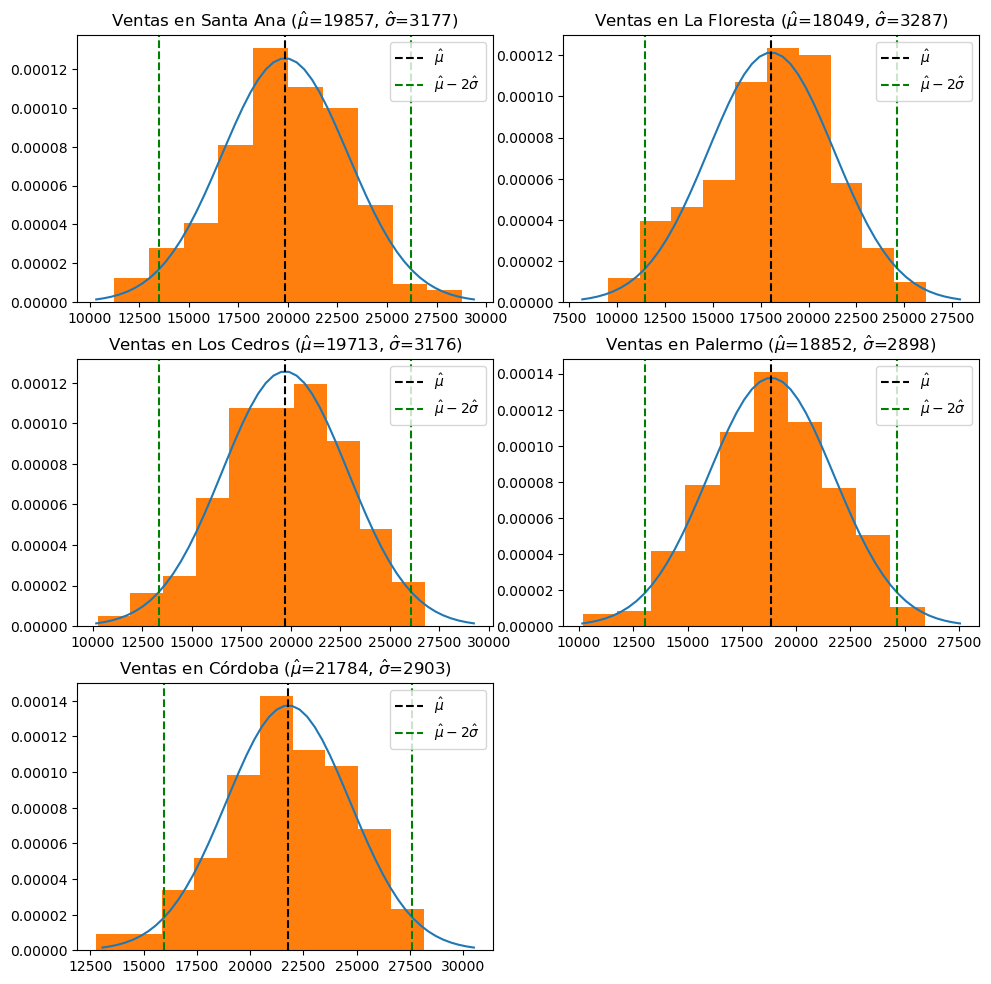

In [5]:
stores = ['Santa Ana', 'La Floresta', 'Los Cedros', 'Palermo', 'Córdoba']
sales_by_stores = [pd.read_excel('Datos_examen_final_17Co2024_Grupo4.xlsx', sheet_name=store)["Ventas"] for store in stores]
from scipy import stats
def sales_per_store_plot_fun(data, ax, index):    
    μ = np.mean(data)
    σ = np.std(data)
    x_axis = np.linspace(μ-3*σ,μ+3*σ)
    ax.plot(x_axis,norm.pdf(x_axis, μ, σ))    
    ax.hist(data, density=True)
    ax.axvline(μ, color='black', linestyle='dashed', label=r'$\hat{\mu}$')
    ax.axvline(μ-2*σ, linestyle='dashed', color='green',label=r'$\hat{\mu}-2\hat{\sigma}$')
    ax.axvline(μ+2*σ, linestyle='dashed', color='green')
    ax.title.set_text(f'Ventas en {stores[index]} ('+r'$\hat{\mu}$'+f'={μ:.0f}' + ', ' + r'$\hat{\sigma}$'+f'={σ:.0f})')
    ax.legend()
plot_sales(sales_by_stores,  sales_per_store_plot_fun , n=2)

Las muestras son independientes, ya que se tomaron al mismo tiempo en 5 lugares ubicados en lugares completamente distintos. 

Se puede ver que la suposición de que las distribuciones son normales es correcta.

Y en cuanto a la homocedasticidad, también es válida ya que los desvío estándar estimados se encuentran entre 2900 y 3300 aproximadamente.

In [6]:
from scipy.stats import f_oneway
f_stat, p_value = f_oneway(*sales_by_stores)

alpha = 0.05
print('f_stat:', f'{f_stat:.2f}')
print('p_value:', p_value)

if p_value < alpha:
    print("Se rechaza H0. Hay evidencia para afirmar que al menos una media es diferente.")
else: 
    print("No se rechaza H0. No hay evidencia suficiente de que las medias son diferentes.")

f_stat: 74.25
p_value: 2.33542094320321e-58
Se rechaza H0. Hay evidencia para afirmar que al menos una media es diferente.


## 3. Identifiquen la tienda con mayor promedio de ventas y la tienda con menor promedio de ventas y realicen una prueba de hipótesis para determinar si la diferencia entre ellas es distinta de 0 o no.

https://en.wikipedia.org/wiki/Paired_difference_test

In [7]:
import pandas as pd
sheets = ['Santa Ana', 'La Floresta', 'Los Cedros', 'Palermo', 'Córdoba']
sales_by_sheets = [pd.read_excel('Datos_examen_final_17Co2024_Grupo4.xlsx', sheet_name=sheet)["Ventas"] for sheet in sheets]

mean_sales_by_sheets = [np.mean(sales) for sales in sales_by_sheets]
for i,sheet in enumerate(sheets):
    print(f'Promedio de ventas en {sheet}: {mean_sales_by_sheets[i]:.2f}')


Promedio de ventas en Santa Ana: 19856.50
Promedio de ventas en La Floresta: 18049.11
Promedio de ventas en Los Cedros: 19713.10
Promedio de ventas en Palermo: 18851.66
Promedio de ventas en Córdoba: 21784.30


In [8]:
min_mean_sales_sheet_idx = np.argmin(mean_sales_by_sheets)
max_mean_sales_sheet_idx = np.argmax(mean_sales_by_sheets)
min_mean_sales_sheet = sheets[min_mean_sales_sheet_idx]
max_mean_sales_sheet = sheets[max_mean_sales_sheet_idx]
print(f'Menor promedio de ventas en {min_mean_sales_sheet}')
print(f'Mayor promedio de ventas en {max_mean_sales_sheet}')

Menor promedio de ventas en La Floresta
Mayor promedio de ventas en Córdoba


Test de hipótesis:

H0: 
$$
\mu_1 = \mu_2
$$
H1: 
$$
\mu_1 \neq \mu_2
$$

Se verifica que N > 30 para utilizar el estadístico Z
Tamaño de la muestra de g1:  365
Tamaño de la muestra de g2:  365
Estadístico: -16.2497
Valor Crítico: 1.9600
Nivel de significancia: 0.05
Se rechaza H0. Hay evidencia suficiente para afirmar que las medias son diferentes


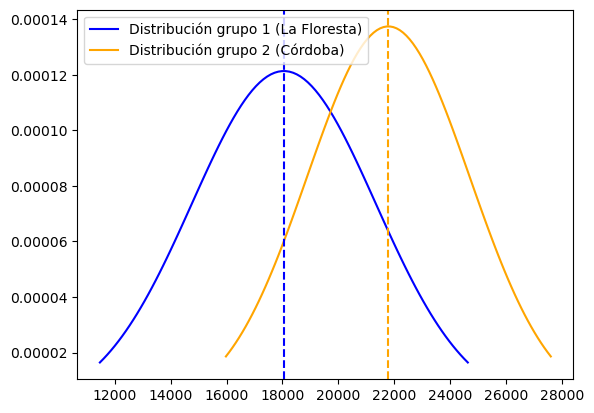

In [9]:
from scipy import stats

g1 = sales_by_sheets[min_mean_sales_sheet_idx]
g2 = sales_by_sheets[max_mean_sales_sheet_idx]

print("Se verifica que N > 30 para utilizar el estadístico Z")
print("Tamaño de la muestra de g1: ", len(g1))
print("Tamaño de la muestra de g2: ", len(g2))

mu_g1 = np.mean(g1)
mu_g2 = np.mean(g2)
varianza_g1 = np.var(g1, ddof=1)
varianza_g2 = np.var(g2, ddof=1)

error_estandar = np.sqrt((varianza_g1 / len(g1)) + (varianza_g2 / len(g2)))

z_stat = (mu_g1 - mu_g2)/error_estandar

alpha = 0.05

z_critico = stats.norm.ppf(1 - alpha/2)

print(f'Estadístico: {z_stat:.4f}')
print(f'Valor Crítico: {z_critico:.4f}')
print(f'Nivel de significancia: {alpha}')

if abs(z_stat) > z_critico:
    print("Se rechaza H0. Hay evidencia suficiente para afirmar que las medias son diferentes")
else:
    print("No se rechaza H0. No hay evidencia suficiente para afirmar que las medias son diferentes")
    

x1 = np.linspace(mu_g1 - 2*np.std(g1), mu_g1+2*np.std(g1), 100) 
x2 = np.linspace(mu_g2 - 2*np.std(g2), mu_g2+2*np.std(g2), 100) 

y1 = stats.norm.pdf(x1, loc=mu_g1, scale=np.std(g1))
y2 = stats.norm.pdf(x2, loc=mu_g2, scale=np.std(g2))

plt.title('')
plt.plot(x1, y1, label='Distribución grupo 1 (La Floresta)', color='blue')
plt.plot(x2, y2, label='Distribución grupo 2 (Córdoba)', color='orange')
plt.axvline(mu_g1, color='blue', linestyle='dashed')
plt.axvline(mu_g2, color='orange', linestyle='dashed')
plt.legend()

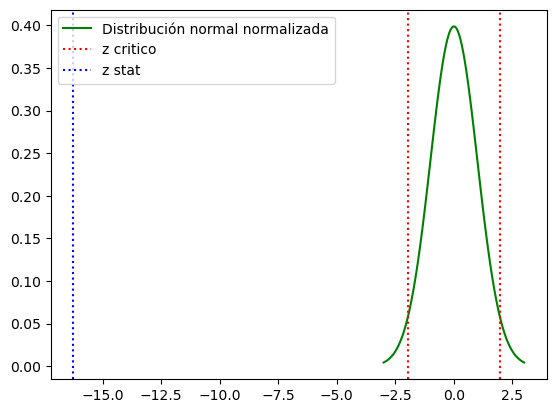

In [10]:
x = np.linspace(-3,3,100) 
y = stats.norm.pdf(x, loc=0, scale=1)
plt.plot(x,y, color='green', label='Distribución normal normalizada')
plt.legend()
plt.axvline(z_critico, color='red', linestyle='dotted', label='z critico')
plt.axvline(-z_critico, color='red', linestyle='dotted')
plt.axvline(z_stat, color='blue', linestyle='dotted', label='z stat')
plt.legend()

## 4. Determinen la distribución a posteriori del parámetro p de porcentaje de morosidad. Determinar su media y su varianza

Para aplicar un enfoque bayesiano utilizando una distribución Beta, se debe estar seguro de que la situación que se modela es compatible con este tipo de proceso. Esto significa que la forma en que se recopilan los datos debe reflejar un escenario donde:

- Se tiene un número fijo de clientes (en este caso, 10).
- Cada cliente tiene una probabilidad 𝑝 de caer en mora.
- La observación de si cada cliente cae en mora o no es independiente de los otros.

La distribución Beta B(α,β) es elegida como a priori porque es una distribución conjugada para la distribución binomial, lo que significa que la a posteriori también será una distribución Beta. La elección de 𝛼=2 y 𝛽=2 indica una creencia inicial que es moderada y simétrica.

- Moderada: Significa que antes de observar los datos, Matías no tiene una fuerte creencia de que la probabilidad de mora sea muy alta o muy baja. Al usar 𝛼=2 y 𝛽=2, está diciendo que espera que la probabilidad de mora esté cerca de 0.5, pero con poca certeza (porque los valores de β son pequeños).

- Simétrica: Se refiere a que 𝛼=𝛽. Esto significa que la distribución a priori es simétrica alrededor de 
𝑝=0.5, indicando que Matías considera igualmente probable que la tasa de mora sea superior o inferior a 0.5 antes de observar los datos.

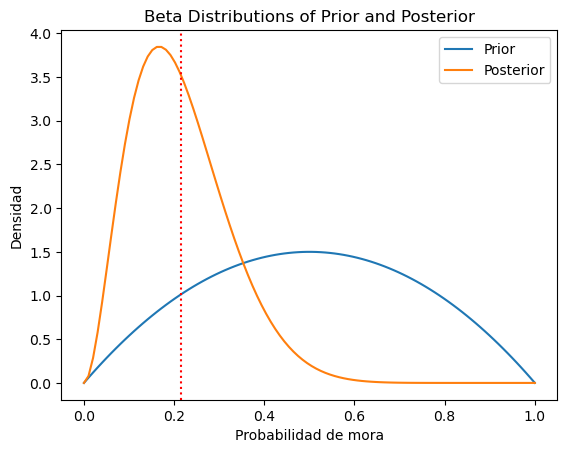

La media es: 0.21428571428571427
La varianza es: 0.011224489795918367


In [11]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

# Prior belief: Beta distribution with alpha=2, beta=2 (symmetric belief)
alpha_prior = 2
beta_prior = 2

# observaciones de pagos
mora, pago = 1, 9

# Update the prior to get the posterior distribution
alpha_posterior = alpha_prior + mora
beta_posterior = beta_prior + pago

mu_posterior = beta.mean(alpha_posterior, beta_posterior)
var_posterior = beta.var(alpha_posterior, beta_posterior)

x = np.linspace(0, 1, 100)

plt.plot(x, beta.pdf(x, alpha_prior, beta_prior), label='Prior')
plt.plot(x, beta.pdf(x, alpha_posterior, beta_posterior), label='Posterior')
plt.title('Beta Distributions of Prior and Posterior')
plt.xlabel('Probabilidad de mora')
plt.ylabel('Densidad')
plt.axvline(mu_posterior, color='red', linestyle='dotted')
plt.legend()
plt.show() 

print(f'La media es: {mu_posterior}')
print(f'La varianza es: {var_posterior}')


Antes de observar los datos, Matías considera que hay una posibilidad moderada y equilibrada (50/50) de que un cliente esté en mora o no. Esto se debe a que la distribución 𝐵(2,2) es simétrica y no favorece ni a los éxitos ni a los fracasos.

La creencia moderada se debe a los valores pequeños de 𝛼 y 𝛽, lo que significa que Matías no tiene evidencia sólida antes de observar los datos y, por tanto, su creencia inicial no está fuertemente inclinada hacia ninguna dirección.

La media de la distribución posterior es menor que la de la distribución a priori, lo que sugiere que, después de observar que solo 1 de 10 clientes ha caído en mora, la probabilidad estimada de que un cliente promedio esté en mora ha disminuido en comparación con la creencia inicial. Esto indica que, según los datos observados, se estima que la probabilidad de mora es alrededor del 21.4%. La distribución posterior es más concentrada (menos dispersa) que la distribución a priori, lo que significa que ahora tienes más certeza sobre esta estimación en comparación con la creencia inicial. Esto se refleja en una varianza menor.

Dado que la mayor parte de la densidad de la distribución posterior está concentrada en valores bajos de la probabilidad de mora (cerca de 0.214), Matías podría explicarle a Don Francisco que, basándose en los datos actuales, los clientes tienen una alta probabilidad de pagar sus deudas a tiempo.